In [24]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

In [25]:
def import_cleaned_data(file_path):

    df = pd.read_csv(file_path)
    return df

cleaned_data = import_cleaned_data('cleaned_data_final.csv')

print(f"Cleaned data shape: {cleaned_data.shape}")
cleaned_data

Cleaned data shape: (222, 10)


,year_month,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg
0,2007-01,30652000,55000,267567000.0000,280671000.0000,36.1800,54.8000,65.1200,2103.5052,75.1683
1,2007-02,26790000,44000,237979000.0000,249005000.0000,35.7500,55.1000,72.9100,2208.9925,81.4653
2,2007-03,31717000,119000,230410000.0000,217339000.0000,35.0600,53.1000,69.6200,2309.4022,78.6261
3,2007-04,27788000,184000,180185000.0000,178575000.0000,34.8700,56.1000,72.8400,2291.3077,80.9071
4,2007-05,32905000,91000,178103000.0000,209215000.0000,34.6200,58.6000,71.4700,2216.0262,82.0040
...,...,...,...,...,...,...,...,...,...,...
217,2025-02,109368000,63000,369222000.0000,1050152000.0000,33.9385,50.2000,67.9100,2367.5498,82.4825
218,2025-03,95398000,111000,369396000.0000,999197000.0000,33.9768,50.5000,66.5600,2428.6617,81.3680
219,2025-04,69306000,73000,317716000.0000,879970000.0000,33.9148,49.0000,59.6900,1974.1805,73.9204
220,2025-05,90856000,123000,360478000.0000,844821000.0000,33.1076,49.5000,64.0500,2012.6110,73.7788


In [26]:
def time_features(df):
    df = df.copy()
    df['month'] = pd.to_datetime(df['year_month']).dt.month
    df['quarter'] = pd.to_datetime(df['year_month']).dt.quarter
    df['year'] = pd.to_datetime(df['year_month']).dt.year
    
    # Seasonal
    df['is_season'] = df['month'].apply(lambda x: 1 if 5 <= x <= 6 else 0)
    
    return df

In [27]:
def supply_demand_features(df):
    df = df.copy()

    if 'export_volume' in df.columns and 'import_volume' in df.columns:
        df['net_export'] = df['export_volume'] - df['import_volume']

    if all(col in df.columns for col in [
        'thai_production',
        'import_volume',
        'export_volume',
        'domestic_consumption'
    ]):
        df['supply_demand_balance'] = (df['thai_production'] + df['import_volume'] - df['export_volume'] - df['domestic_consumption']
        )

    if 'stock' in df.columns and 'domestic_consumption' in df.columns:
        df['stock_consumption_ratio'] = df['stock'] / df['domestic_consumption'].replace(0, np.nan)

    if 'thai_production' in df.columns:
        df['production_growth'] = df['thai_production'].pct_change() * 100

    return df


In [28]:
def rolling_features(df):
    df = df.copy()
    
    roll_vars = ['thai_price', 'world_price_thb_kg', 'oil_price_thb', 'china_pmi']
    windows = [3, 6, 12]
    
    for var in roll_vars:
        if var in df.columns:
            for window in windows:
                # Moving Average
                df[f'{var}_ma{window}'] = df[var].rolling(window=window).mean()
                # Rolling Std
                df[f'{var}_std{window}'] = df[var].rolling(window=window).std()
    
    return df

In [29]:
def rate_of_change(df):
    df = df.copy()
    
    change_vars = ['thai_price', 'world_price_thb_kg', 'oil_price_thb', 
                   'exchange_rate_usd', 'thai_production']
    periods = [1, 3, 6, 12]
    
    for var in change_vars:
        if var in df.columns:
            for period in periods:
                df[f'{var}_pct{period}'] = df[var].pct_change(periods=period) * 100
    
    return df

In [30]:
def lag_features(df):
    df = df.copy()
    
    # Lag features สำหรับตัวแปรที่มีผลต่อราคา
    lag_vars = ['thai_price', 'world_price_thb_kg', 'oil_price_thb',
                'china_pmi', 'thai_production', 'stock','exchange_rate_usd',
                'net_export', 'supply_demand_balance',
                'stock_consumption_ratio', 'production_growth']
    
    lag_periods = [1, 3, 6, 12]
    
    for var in lag_vars:
        if var in df.columns:
            for lag in lag_periods:
                df[f'{var}_lag{lag}'] = df[var].shift(lag)
    
    return df

In [31]:
def missing_values(df):
    df = df.copy()
    
    # Lag features - ใช้ forward fill
    lag_cols = [col for col in df.columns if '_lag' in col]
    for col in lag_cols:
        df[col] = df[col].fillna(method='ffill')
        df[col] = df[col].fillna(df[col].mean())
    
    # Rolling features - ใช้ backward fill ก่อน แล้วค่อย forward fill
    rolling_cols = [col for col in df.columns if '_ma' in col or '_std' in col]
    for col in rolling_cols:
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    
    # Rate of Change - ใช้ 0 (ไม่มีการเปลี่ยนแปลง)
    pct_cols = [col for col in df.columns if '_pct' in col]
    for col in pct_cols:
        df[col] = df[col].fillna(0)
    
    remaining_nulls = df.isnull().sum()
    if remaining_nulls.sum() > 0:
        print("\nWarning: Still have NaN values:")
        print(remaining_nulls[remaining_nulls > 0])
    else:
        print("\nAll NaN values handled successfully")
    
    return df

In [32]:
df_final = time_features(cleaned_data)
df_final = rolling_features(df_final)
df_final = rate_of_change(df_final)
df_final = supply_demand_features(df_final)
df_final = lag_features(df_final)
df_final = missing_values(df_final)

print(f"\nAfter feature engineering: {df_final.shape}")
print(f"\nFeature engineered data col: {df_final.columns}")
df_final


All NaN values handled successfully

After feature engineering: (222, 88)

Feature engineered data col: Index(['year_month', 'domestic_consumption', 'import_volume', 'export_volume',
       'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price',
       'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year',
       'is_season', 'thai_price_ma3', 'thai_price_std3', 'thai_price_ma6',
       'thai_price_std6', 'thai_price_ma12', 'thai_price_std12',
       'world_price_thb_kg_ma3', 'world_price_thb_kg_std3',
       'world_price_thb_kg_ma6', 'world_price_thb_kg_std6',
       'world_price_thb_kg_ma12', 'world_price_thb_kg_std12',
       'oil_price_thb_ma3', 'oil_price_thb_std3', 'oil_price_thb_ma6',
       'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12',
       'china_pmi_ma3', 'china_pmi_std3', 'china_pmi_ma6', 'china_pmi_std6',
       'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct1',
       'thai_price_pct3', 'thai_price_pct6', 'thai_price_pct12',
      

C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_39448\639554798.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_39448\639554798.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill').fillna(method='ffill')


,year_month,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg,...,exchange_rate_usd_lag6,exchange_rate_usd_lag12,net_export_lag1,net_export_lag3,net_export_lag6,net_export_lag12,stock_consumption_ratio_lag1,stock_consumption_ratio_lag3,stock_consumption_ratio_lag6,stock_consumption_ratio_lag12
0,2007-01,30652000,55000,267567000.0000,280671000.0000,36.1800,54.8000,65.1200,2103.5052,75.1683,...,33.0173,32.9731,303540454.7511,303216632.4201,302252618.0556,301211654.7619,10.2726,10.2660,10.2724,10.0018
1,2007-02,26790000,44000,237979000.0000,249005000.0000,35.7500,55.1000,72.9100,2208.9925,81.4653,...,33.0173,32.9731,267512000.0000,303216632.4201,302252618.0556,301211654.7619,9.1567,10.2660,10.2724,10.0018
2,2007-03,31717000,119000,230410000.0000,217339000.0000,35.0600,53.1000,69.6200,2309.4022,78.6261,...,33.0173,32.9731,237935000.0000,303216632.4201,302252618.0556,301211654.7619,9.2947,10.2660,10.2724,10.0018
3,2007-04,27788000,184000,180185000.0000,178575000.0000,34.8700,56.1000,72.8400,2291.3077,80.9071,...,33.0173,32.9731,230291000.0000,267512000.0000,302252618.0556,301211654.7619,6.8524,9.1567,10.2724,10.0018
4,2007-05,32905000,91000,178103000.0000,209215000.0000,34.6200,58.6000,71.4700,2216.0262,82.0040,...,33.0173,32.9731,180001000.0000,237935000.0000,302252618.0556,301211654.7619,6.4263,9.2947,10.2724,10.0018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2025-02,109368000,63000,369222000.0000,1050152000.0000,33.9385,50.2000,67.9100,2367.5498,82.4825,...,34.9201,36.0180,379433000.0000,364414000.0000,350013000.0000,341990000.0000,9.3505,9.8379,7.0351,9.3676
218,2025-03,95398000,111000,369396000.0000,999197000.0000,33.9768,50.5000,66.5600,2428.6617,81.3680,...,33.5273,36.1130,369159000.0000,348725000.0000,302592000.0000,331968000.0000,9.6020,77.7513,8.3272,9.7302
219,2025-04,69306000,73000,317716000.0000,879970000.0000,33.9148,49.0000,59.6900,1974.1805,73.9204,...,33.5266,36.9506,369285000.0000,379433000.0000,339774000.0000,274658000.0000,10.4740,9.3505,6.5573,8.9713
220,2025-05,90856000,123000,360478000.0000,844821000.0000,33.1076,49.5000,64.0500,2012.6110,73.7788,...,34.6097,36.7966,317643000.0000,369159000.0000,364414000.0000,291251000.0000,12.6969,9.6020,9.8379,10.5795


Top 30 features with |correlation| > 0.3:
thai_price_ma3             0.9765
world_price_thb_kg_ma3     0.9693
thai_price_lag1            0.9590
world_price_thb_kg_lag1    0.9580
thai_price_ma6             0.9252
world_price_thb_kg_ma6     0.9171
thai_price_lag3            0.8634
world_price_thb_kg_lag3    0.8565
thai_price_ma12            0.8329
world_price_thb_kg_ma12    0.8224
thai_price_lag6            0.7145
world_price_thb_kg_lag6    0.7068
world_price_thb_kg_std12   0.6346
world_price_thb_kg_std6    0.6070
thai_price_std12           0.5970
world_price_thb_kg_std3    0.5757
thai_price_std6            0.5710
net_export_lag12           0.5588
china_pmi_ma12             0.5587
thai_price_std3            0.5410
china_pmi_ma6              0.5301
net_export_lag6            0.5103
thai_price_lag12           0.5097
world_price_thb_kg_pct12   0.5078
world_price_thb_kg_lag12   0.5077
stock_lag6                 0.5035
oil_price_thb_ma3          0.4968
thai_price_pct12           0.4951
oil_pr

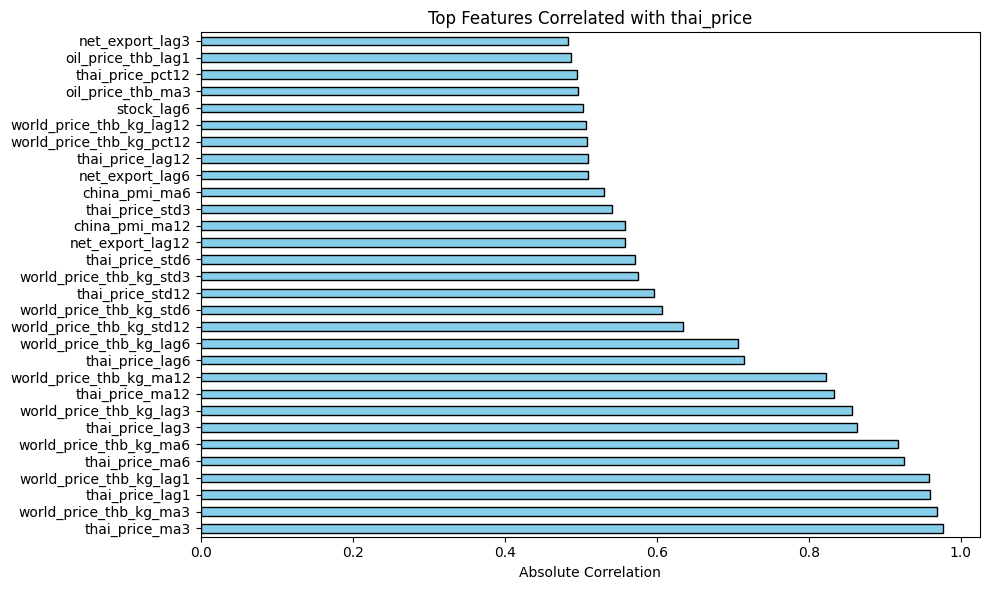


Selected 30 features


In [36]:
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

def select_features_by_correlation(df, target='thai_price', threshold=0.3, top_n=20):
    df = df.copy()
    
    # ตัดคอลัมน์ที่ไม่ใช่ numeric ออก (เช่น year_month)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_cols]

    # เอาปัจจัยปัจจุบันออก
    exclude_cols = ['domestic_consumption', 'import_volume', 'export_volume',
       'stock', 'exchange_rate_usd', 'china_pmi',
       'oil_price_thb', 'world_price_thb_kg']
    
    df_numeric = df_numeric.drop(columns=exclude_cols, errors='ignore')

    if target not in df_numeric.columns:
        print(f"Error: '{target}' not found in numeric columns")
        print(f"Available numeric columns: {df_numeric.columns.tolist()}")
        return []
    
    # คำนวณ correlation กับ target
    correlations = df_numeric.corr()[target].abs().sort_values(ascending=False)
    
    # ตัด target ออก และเลือกที่มีค่ามากกว่า threshold
    correlations = correlations.drop(target)
    selected = correlations[correlations > threshold].head(top_n)
    
    print(f"Top {len(selected)} features with |correlation| > {threshold}:")
    print(selected)
    
    plt.figure(figsize=(10, 6))
    selected.head(50).plot(kind='barh', color='skyblue', edgecolor='black')
    plt.title(f'Top Features Correlated with {target}')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.show()
    
    return selected.index.tolist()

selected_features = select_features_by_correlation(df_final, target='thai_price', threshold=0.3, top_n=30)
print(f"\nSelected {len(selected_features)} features")